# House prices

Kairos (April 2018)


## Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

## Data
79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa.

## Challenge
Predicting the final price of each home.

## Method
We'll use Tensorflow as out method to develop the project.

## Synthetic Features and Outliers
This notebook continues the linear regression model started in the previous exercise. In this exercise, we'll try new features and study the effect of outliers in the input data.

## 1. Set Up
In this first cell, we'll load the necessary libraries.

In [151]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.contrib.learn.python.learn import learn_io, estimator

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

## 2. Load our data set
Next, we'll load our data set and show information about it.

In [152]:
housing_dataframe = pd.read_csv("input/train.csv", sep=",")
housing_dataframe.shape
housing_dataframe.describe()
housing_dataframe.info()
housing_dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## 3. Clean dirty data

### Handle Missing Values
Let's compute the number of missing values and determine how to handle them.


In [153]:
null_counts = housing_dataframe.isnull().sum()
import itertools
print("Number of null values in each column:\n")
for name, val in itertools.izip(null_counts.index, null_counts):
    if val > 0:
      print name, val


Number of null values in each column:

LotFrontage 259
Alley 1369
MasVnrType 8
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406


Notice while most of the columns have 0 missing values, there are 18 that don't.
Let's remove columns entirely where more than 1% of the rows for that column contain a null value. In addition, we'll remove the remaining rows containing null values, which means we'll lose a bit of data, but in return keep some extra features to use for prediction.

### Let's remove columns entirely where more than 1% (15) of the rows for that column contain a null value.

In [154]:
cols = []
for name, val in itertools.izip(null_counts.index, null_counts):
    if val > 15:
      cols.append(name)

housing_dataframe.drop(cols, inplace=True, axis=1)
housing_dataframe   

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125


### Let's see the rest of columns with NaN values

In [155]:
null_counts = housing_dataframe.isnull().sum()
print("Number of null values in each column:\n\n")
for name, val in itertools.izip(null_counts.index, null_counts):
    if val > 0:
      print name, val


Number of null values in each column:


MasVnrType 8
MasVnrArea 8
Electrical 1


### Let's use the dropna method to remove all rows from 'MasVnrType', 'MasVnrArea' and 'Electrical' containing any missing values.

In [156]:
housing_dataframe = housing_dataframe.dropna()


### Let's test there aren't any missing data

In [157]:
#missing data
total = housing_dataframe.isnull().sum().sort_values(ascending=False)
percent = (housing_dataframe.isnull().sum()/housing_dataframe.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

             Total  Percent
SalePrice        0      0.0
TotalBsmtSF      0      0.0
BsmtFinSF2       0      0.0
BsmtFinSF1       0      0.0
Foundation       0      0.0
...            ...      ...
2ndFlrSF         0      0.0
1stFlrSF         0      0.0
Electrical       0      0.0
CentralAir       0      0.0
Id               0      0.0

[65 rows x 2 columns]


### Let's investigate Categorical Columns
Keep in mind, the goal in this section is to have all the columns as numeric columns (int or float data type), and containing no missing values. We just dealt with the missing values, so let's now find out the number of columns that are of the object data type and then move on to process them into numeric form.

In [158]:
print("Data types and their frequency\n{}".format(housing_dataframe.dtypes.value_counts()))


Data types and their frequency
int64      35
object     29
float64     1
dtype: int64


We have 29 object columns that contain text which need to be converted into numeric features. Let's select just the object columns using the DataFrame method select_dtype, then display a sample row to get a better sense of how the values in each column are formatted.

In [159]:
object_columns_df = housing_dataframe.select_dtypes(include=['object'])
print(object_columns_df.iloc[0])


MSZoning             RL
Street             Pave
LotShape            Reg
LandContour         Lvl
Utilities        AllPub
                  ...  
KitchenQual          Gd
Functional          Typ
PavedDrive            Y
SaleType             WD
SaleCondition    Normal
Name: 0, dtype: object


 These columns seem to represent categorical values.

In [160]:
object_filter_df = housing_dataframe.select_dtypes(include=['object']).copy()
object_filter_df


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,PConc,GasA,Ex,Y,SBrkr,Gd,Typ,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,CBlock,GasA,Ex,Y,SBrkr,TA,Typ,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,PConc,GasA,Ex,Y,SBrkr,Gd,Typ,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,BrkTil,GasA,Gd,Y,SBrkr,Gd,Typ,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,PConc,GasA,Ex,Y,SBrkr,Gd,Typ,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,PConc,GasA,Ex,Y,SBrkr,TA,Typ,Y,WD,Normal
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,CBlock,GasA,TA,Y,SBrkr,TA,Min1,Y,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,Stone,GasA,Ex,Y,SBrkr,Gd,Typ,Y,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,CBlock,GasA,Gd,Y,FuseA,Gd,Typ,Y,WD,Normal


### Let's convert these columns to values by category
    1. Convert character/object to values.
    2. Drop columns from housing_dataframe.
    3. Concatenate both dataframes.

In [161]:
# Create a values dataframe for new values
values_df = object_filter_df.select_dtypes(include=['object']).copy()

char_cols = object_filter_df.dtypes.pipe(lambda x: x[x == 'object']).index

for c in char_cols:
    values_df[c] = pd.factorize(object_filter_df[c])[0]
    # Dropping columns
    housing_dataframe.drop(c, inplace=True, axis=1)

# Concatenating both dataframes
housing_dataframe = pd.concat([housing_dataframe, values_df], axis=1)    
housing_dataframe   
    

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
0,1,60,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,0,0,0,0,0,0
1,2,20,9600,6,8,1976,1976,0.0,978,0,...,1,0,0,0,0,1,0,0,0,0
2,3,60,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,0,0,0,0,0,0
3,4,70,9550,7,5,1915,1970,0.0,216,0,...,2,0,1,0,0,0,0,0,0,1
4,5,60,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,7917,6,5,1999,2000,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1456,1457,20,13175,6,6,1978,1988,119.0,790,163,...,1,0,2,0,0,1,1,0,0,0
1457,1458,70,9042,7,9,1941,2006,0.0,275,0,...,5,0,0,0,0,0,0,0,0,0
1458,1459,20,9717,5,6,1950,1996,0.0,49,1029,...,1,0,1,0,2,0,0,0,0,0


### Let's check everything is ok
Every column is int or float type in housing_dataframe.

In [162]:
housing_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1459
Data columns (total 65 columns):
Id               1451 non-null int64
MSSubClass       1451 non-null int64
LotArea          1451 non-null int64
OverallQual      1451 non-null int64
OverallCond      1451 non-null int64
YearBuilt        1451 non-null int64
YearRemodAdd     1451 non-null int64
MasVnrArea       1451 non-null float64
BsmtFinSF1       1451 non-null int64
BsmtFinSF2       1451 non-null int64
BsmtUnfSF        1451 non-null int64
TotalBsmtSF      1451 non-null int64
1stFlrSF         1451 non-null int64
2ndFlrSF         1451 non-null int64
LowQualFinSF     1451 non-null int64
GrLivArea        1451 non-null int64
BsmtFullBath     1451 non-null int64
BsmtHalfBath     1451 non-null int64
FullBath         1451 non-null int64
HalfBath         1451 non-null int64
BedroomAbvGr     1451 non-null int64
KitchenAbvGr     1451 non-null int64
TotRmsAbvGrd     1451 non-null int64
Fireplaces       1451 non-null int64
Gar

### Let's create a dictionary to save the encoding for future use.

In [142]:
char_cols = object_filter_df.dtypes.pipe(lambda x: x[x == 'object']).index
label_mapping = {}

for c in char_cols:
    object_filter_df[c], label_mapping[c] = pd.factorize(object_filter_df[c])
print label_mapping    

{'MasVnrType': Index([u'None', u'BrkFace', u'Stone', u'BrkCmn'], dtype='object'), 'LotConfig': Index([u'Inside', u'FR2', u'CulDSac', u'Corner', u'FR3'], dtype='object'), 'Exterior1st': Index([u'Plywood', u'BrkFace', u'MetalSd', u'CemntBd', u'VinylSd', u'Wd Sdng',
       u'HdBoard', u'Stucco', u'WdShing', u'AsbShng', u'Stone', u'AsphShn',
       u'BrkComm', u'ImStucc', u'CBlock'],
      dtype='object'), 'Electrical': Index([u'SBrkr', u'FuseA', u'Mix', u'FuseF', u'FuseP'], dtype='object'), 'HouseStyle': Index([u'1Story', u'1.5Fin', u'SLvl', u'2Story', u'1.5Unf', u'SFoyer',
       u'2.5Unf', u'2.5Fin'],
      dtype='object'), 'Foundation': Index([u'PConc', u'BrkTil', u'CBlock', u'Slab', u'Wood', u'Stone'], dtype='object'), 'HeatingQC': Index([u'Ex', u'Gd', u'TA', u'Fa', u'Po'], dtype='object'), 'RoofStyle': Index([u'Hip', u'Gable', u'Gambrel', u'Mansard', u'Shed', u'Flat'], dtype='object'), 'CentralAir': Index([u'Y', u'N'], dtype='object'), 'Utilities': Index([u'AllPub', u'NoSeWa'], dtype

## 4. Save clean data to CSV
It is a good practice to store the final output of each section or stage of your workflow in a separate csv file. One of the benefits of this practice is that it helps us to make changes in our data processing flow without having to recalculate everything.

In [163]:
housing_dataframe.to_csv("input/cleaned_houses_prices.csv",index=False)

## 5. Random the data
We'll randomize the data, just to be sure not to get any pathological ordering effects that might harm the performance of Stochastic Gradient Descent. Additionally, we scale "SalePrice" to be in units of thousands, so it can be learned a little more easily with learning rates in a range that we usually use.

In [164]:
housing_dataframe = housing_dataframe.reindex(
    np.random.permutation(housing_dataframe.index))
housing_dataframe["SalePrice"] /= 1000.0
housing_dataframe

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
1180,1181,60,11170,7,5,1990,1991,0.0,1216,0,...,3,0,0,0,0,1,0,0,0,0
1378,1379,160,1953,6,5,1973,1973,408.0,309,0,...,1,0,2,0,0,1,0,0,0,0
923,924,120,8012,6,5,1993,1994,0.0,165,841,...,0,0,0,0,0,0,0,0,0,0
1104,1105,160,2016,5,5,1970,1970,304.0,0,0,...,1,0,2,0,0,1,0,0,0,0
1181,1182,120,5587,8,5,2008,2008,186.0,1480,0,...,0,0,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,113,60,9965,7,5,2007,2007,220.0,984,0,...,0,0,0,0,0,2,0,0,1,2
566,567,60,11198,9,5,2005,2007,245.0,0,0,...,0,0,0,0,0,2,0,0,0,0
1005,1006,80,8385,5,8,1977,1977,220.0,595,0,...,1,0,2,0,0,1,0,0,0,0
740,741,70,9600,5,7,1910,2002,0.0,0,0,...,2,0,0,0,0,1,0,0,0,1


## 6. Examine the data
It's a good idea to get to know your data a little bit before you work with it.
We'll print out a quick summary of a few useful statistics on each column.
This will include things like mean, standard deviation, max, min, and various quantiles.

In [165]:
housing_dataframe.describe()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
count,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,...,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0
mean,729.4,56.9,10507.8,6.1,5.6,1971.1,1984.8,103.8,442.3,46.8,...,0.7,0.0,0.9,0.1,0.2,0.7,0.2,0.1,0.2,0.3
std,421.7,42.4,9993.0,1.4,1.1,30.2,20.7,181.1,455.4,161.8,...,0.8,0.3,1.0,0.2,0.5,0.7,0.7,0.4,0.8,0.9
min,1.0,20.0,1300.0,1.0,1.0,1872.0,1950.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,364.5,20.0,7537.5,5.0,5.0,1954.0,1966.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,729.0,50.0,9477.0,6.0,5.0,1972.0,1993.0,0.0,381.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
75%,1094.5,70.0,11600.0,7.0,6.0,2000.0,2004.0,166.0,707.0,0.0,...,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
max,1460.0,190.0,215245.0,10.0,9.0,2010.0,2010.0,1600.0,5644.0,1474.0,...,5.0,5.0,4.0,1.0,4.0,3.0,6.0,2.0,8.0,5.0


## 7. Build the first model
In this exercise, we'll be trying to predict "SalePrice". It will be our label (sometimes also called a target). We'll use "TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)" as our input feature.

To train our model, we'll use the LinearRegressor interface provided by the TensorFlow contrib.learn library. This library takes care of a lot of the plumbing, and exposes a convenient way to interact with data, training, and evaluation.

First, we define the input feature, the target, and create the LinearRegressor object.

The GradientDescentOptimizer implements Mini-Batch Stochastic Gradient Descent (SGD), where the size of the mini-batch is given by the batch_size parameter. Note the learning_rate parameter to the optimizer: it controls the size of the gradient step. We also include a value for gradient_clip_norm for safety. This makes sure that gradients are never too huge, which helps avoid pathological cases in gradient descent.

In [166]:
my_feature = housing_dataframe[["TotRmsAbvGrd"]]
targets = housing_dataframe["SalePrice"]

training_input_fn = learn_io.pandas_input_fn(
    x=my_feature, y=targets, num_epochs=None, batch_size=1)

feature_columns = [tf.contrib.layers.real_valued_column("TotRmsAbvGrd", dimension=1)]

linear_regressor = tf.contrib.learn.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.00001),
    gradient_clip_norm=5.0,
)

Calling fit() on the feature column and targets will train the model.

In [167]:
_ = linear_regressor.fit(
    input_fn=training_input_fn,
    steps=100
)

Let's make predictions on that training data, to see how well we fit the training data.

In [168]:
prediction_input_fn = learn_io.pandas_input_fn(
    x=my_feature, y=targets, num_epochs=1, shuffle=False)

predictions = list(linear_regressor.predict(input_fn=prediction_input_fn))

mean_squared_error = metrics.mean_squared_error(predictions, targets)
print "Mean Squared Error (on training data): %0.3f" % mean_squared_error
print "Root Mean Squared Error (on training data): %0.3f" % math.sqrt(mean_squared_error)

Mean Squared Error (on training data): 38898.566
Root Mean Squared Error (on training data): 197.227


In [169]:
def train_model(learning_rate, steps, batch_size, input_feature):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_column = housing_dataframe[[my_feature]]
  my_label = "SalePrice"
  targets = housing_dataframe[my_label]

  # Create feature columns
  feature_columns = [tf.contrib.layers.real_valued_column(my_feature, dimension=1)]
  
  # Create input functions
  training_input_fn = learn_io.pandas_input_fn(
    x=my_feature_column, y=targets, num_epochs=None, batch_size=batch_size)
  prediction_input_fn = learn_io.pandas_input_fn(
    x=my_feature_column, y=targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  linear_regressor = tf.contrib.learn.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate),
      gradient_clip_norm=5.0
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.fit(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = list(linear_regressor.predict(
        input_fn=prediction_input_fn))
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    x_extents = (y_extents - linear_regressor.bias_) / linear_regressor.weights_[0]
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = linear_regressor.weights_[0] * x_extents + linear_regressor.bias_
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print "Model training finished."

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print "Final RMSE (on training data): %0.2f" % root_mean_squared_error
  return calibration_data

## 8. Try a synthetic feature.
Both the "1stFlrSF" and "2ndFlrSF" features count totals for a given house.

We can create a synthetic feature that's a ratio of our two source features.

Create a feature called "totalFlrsSF", and use that as an input in the model code cell below.

What is the best performance you can get with this single feature? (The better the performance, the better your regression line should fit the data and the lower the final RMSE should be.)

Training model...
RMSE (on training data):
  period 00 : 170.64
  period 01 : 144.51
  period 02 : 119.20
  period 03 : 95.35
  period 04 : 74.41
  period 05 : 60.76
  period 06 : 56.55
  period 07 : 55.89
  period 08 : 55.50
  period 09 : 55.89
Model training finished.


,predictions,targets
count,1451.0,1442.0
mean,171.9,180.6
std,59.4,79.4
min,38.1,34.9
25%,127.9,129.9
50%,166.2,162.2
75%,202.2,214.0
max,643.2,755.0


Final RMSE (on training data): 55.89


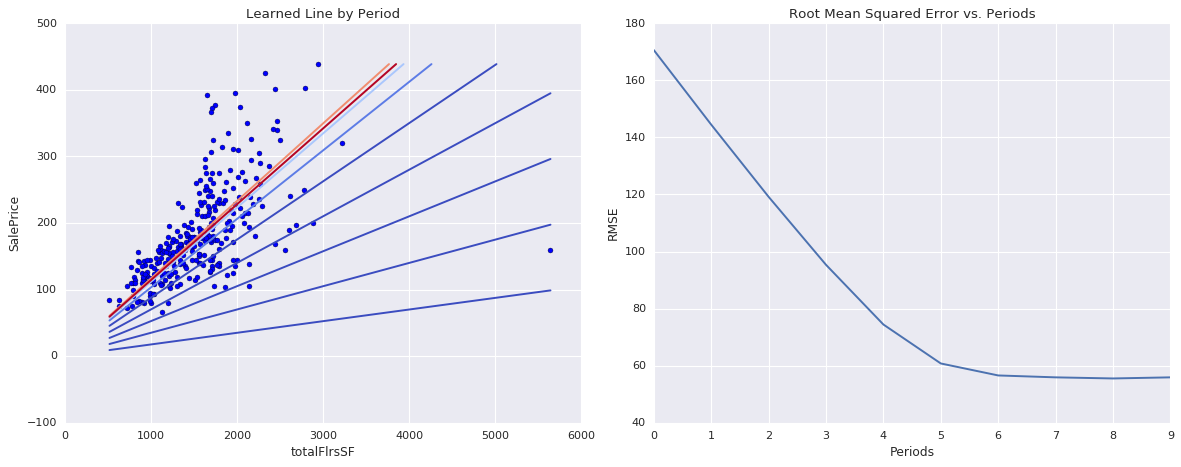

In [170]:
housing_dataframe["totalFlrsSF"] = (
    housing_dataframe["1stFlrSF"] + housing_dataframe["2ndFlrSF"])

calibration_data = train_model(
    learning_rate=0.0001,
    steps=350,
    batch_size=5,
    input_feature="totalFlrsSF")

## 9. Identify outliers
The calibration data shows most scatter points aligned to a line. The line is almost vertical, but we'll come back to that later. Right now let's focus on the ones that deviate from the line. We notice that they are relatively few in number.

Plotting a histogram of "totalFlrsSF" reveals that we have a few outliers in our input data.

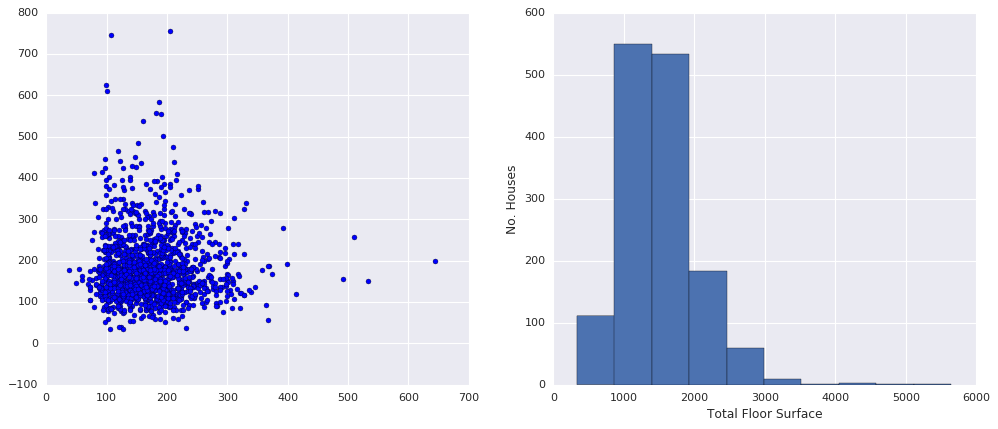

In [171]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(calibration_data["predictions"], calibration_data["targets"])
plt.subplot(1, 2, 2)
plt.ylabel('No. Houses')
plt.xlabel('Total Floor Surface')
_ = housing_dataframe["totalFlrsSF"].hist()

## 10. Clip outliers
See if you can improve model fit further by setting outlier values of totalFlrsSF to some sane minimum or maximum.

For reference, here's a quick example of how to apply a function to a Pandas Series:

clipped_feature = my_feature_column["my_feature_name"].apply(lambda x: max(x, 0))
The above clipped_feature will have no values less than 0.

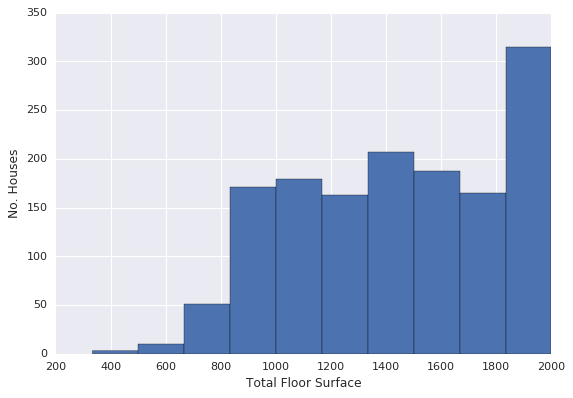

In [175]:
housing_dataframe["totalFlrsSF"] = (
    housing_dataframe["totalFlrsSF"]).apply(lambda x: min(x, 3000))
plt.ylabel('No. Houses')
plt.xlabel('Total Floor Surface')
_ = housing_dataframe["totalFlrsSF"].hist()

To verify that clipping worked, let's train again and print the calibration data once more.

Training model...
RMSE (on training data):
  period 00 : 172.42
  period 01 : 148.07
  period 02 : 124.47
  period 03 : 102.17
  period 04 : 82.21
  period 05 : 68.92
  period 06 : 61.88
  period 07 : 59.77
  period 08 : 60.72
  period 09 : 59.99
Model training finished.


,predictions,targets
count,1451.0,1442.0
mean,172.2,180.6
std,46.3,79.4
min,39.7,34.9
25%,133.5,129.9
50%,173.5,162.2
75%,211.1,214.0
max,238.0,755.0


Final RMSE (on training data): 59.99


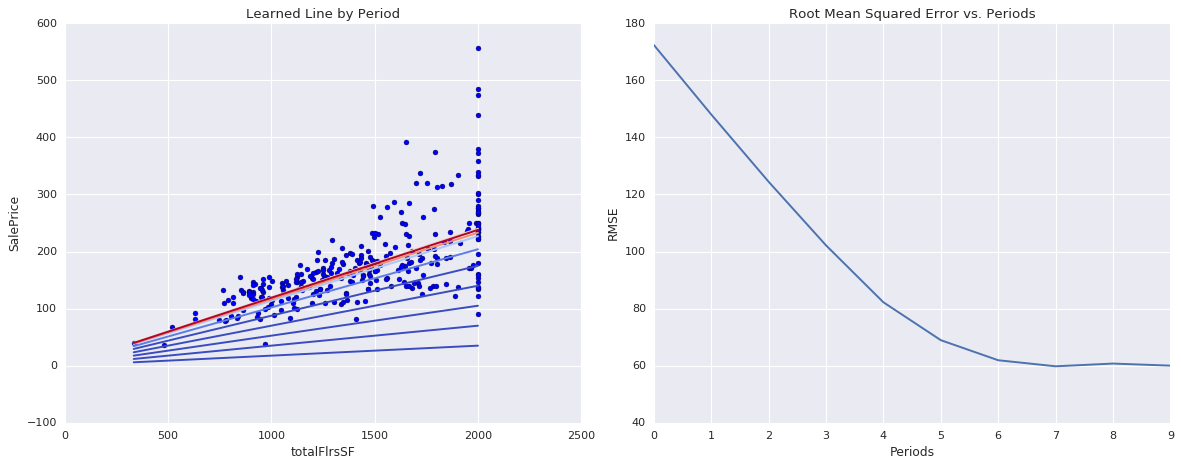

In [173]:
calibration_data = train_model(
    learning_rate=0.0001,
    steps=350,
    batch_size=5,
    input_feature="totalFlrsSF")

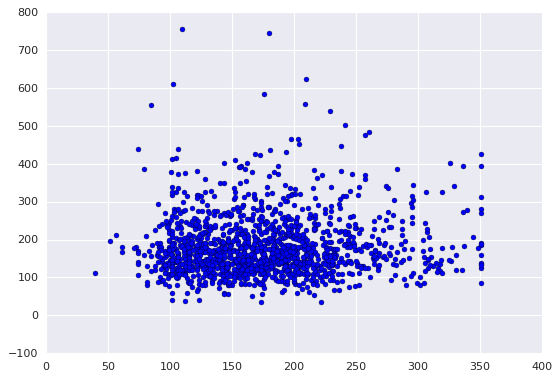

In [37]:
_ = plt.scatter(calibration_data["predictions"], calibration_data["targets"])